# Darcy's Equation

In this tutorial we will assume we have an incompressible fluid. Conservation of mass then gives us
\begin{equation}
\nabla v =  q,
\end{equation}
where $v$ is the fluid velocity and $q$ any source term. 

A common assumption used for flow in porous media is the so called Darcy's law, which relates the flux field to the pressure gradient:
\begin{equation}
v = -\frac{K}{\mu}\nabla p
\end{equation}

We innsert Darcy's law into the equation for conservation of mass to obtain an elliptic equation, which can be solved with respect to the pressure

$$ - \nabla \cdot \rho K \nabla p = \rho f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad - K \nabla p \cdot \mathbf{n} = u_b$$




# Import modules
To solve this equation we need access to NumPy and PorePy.

In [2]:
import numpy as np
import porepy as pp

# Generate grid
We first solve the equation on a single cartesian grid, and will later add fractures to the grid

In [3]:
g = pp.CartGrid([11, 11])
g.compute_geometry()

# Set parameters
We create define dirichlet boundary conditions and a source term, and store them in the data dictionary. 'initialize_data' sets default values for the non-specified parameters, in particular zero boundary values and unitary permeability tensor.

In [6]:
param =  pp.Parameters(g)
dir_bound = np.ravel(np.argwhere(g.tags['domain_boundary_faces']))
bc_cond = pp.BoundaryCondition(g, dir_bound, ['dir']*dir_bound.size)

src = np.zeros(g.num_cells)
src[60] = 1

specified_parameters = {"source": src, "bc": bc_cond}
d = pp.params.data.initialize_data({}, g, "flow", specified_parameters)

# Solve problem
We can now create a Darcy object and solve the problem

Solve elliptic model
Discretize
Done. Elapsed time 0.009915590286254883
Solve linear system using direct solver
Done. Elapsed time 0.002668142318725586


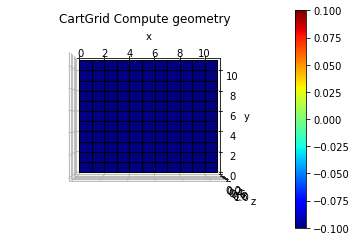

In [7]:
problem = pp.EllipticModel(g, d)
p = problem.solve()
pp.plot_grid(g, p)

# Add fractures
We now try to solve the same problem, but with a fracture in the domain. We create a multidimensional grid:

In [5]:
f = np.array([[0,10],[5,5]])
gb = pp.meshing.cart_grid([f], [10,10])
gb.assign_node_ordering()

We now make use of the DarcyData class to assign data to the fracture and matrix. We wish to set zero dirichlet boundary conditions. However, the data class assigns Neumann conditions by default, so we overload the bc function. We set a small aperture for the fracture, but a high permeability. Note that we let the FractureDomain innherit from the MatrixDomain. This way we assign the same parameters to the fractures as the matrix, unless we overload the parameter function(e.g., the permeabillity) 

In [6]:
class MatrixDomain(pp.EllipticDataAssigner):
    def __init__(self, g, d):
        pp.EllipticDataAssigner.__init__(self, g, d)

    def bc(self):
        dir_bound = np.ravel(np.argwhere(self.grid().tags['domain_boundary_faces']))
        return pp.BoundaryCondition(self.grid(), dir_bound, ['dir']*dir_bound.size)

class FractureDomain(MatrixDomain):
    def __init(self, g, d):
        MatrixDomain.__init__(self, g, d)
        
    def permeability(self):
        kxx = 100 * np.ones(self.grid().num_cells)
        return pp.SecondOrderTensor(2, kxx)
    
    def source(self):
        val = np.ones(self.grid().num_cells)
        val[round(self.grid().num_cells/2)] = 1
        return val
    
    def aperture(self):
        val = 0.01 * np.ones(self.grid().num_cells)
        return val
    
def assign_darcy_data(gb):
    gb.add_node_props(['problem'])
    for g, d in gb:
        if g.dim == 2:
            d['problem'] = MatrixDomain(g, d)
        else:
            d['problem'] = FractureDomain(g, d)
            
    # We loop over the edges and assign coupling permeability
    for e, d in gb.edges():
        d['kn'] = 100

We are now ready to declare the problem and solve it

Solve elliptic model
Discretize
Done. Elapsed time 0.0376279354095459
Solve linear system using direct solver
Done. Elapsed time 0.0019690990447998047


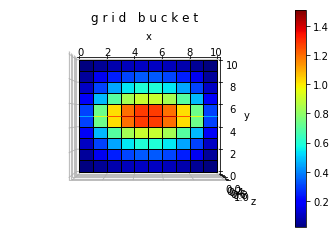

In [7]:
assign_darcy_data(gb)
problem = pp.EllipticModel(gb)
problem.solve()
problem.split('pressure')
pp.plot_grid(gb, 'pressure')

# Change discretization
By default, the darcy solver uses the TPFA discretization for the fluxes. If we set an anisotropic permeability tensor, TPFA will not give a consistent discretization. In these cases we would like to use, e.g., the MPSA discretization. We can do this by overloading the flux_disc() function of the darcy solver. Note that we have already assigned data to the grid, so we do not have to do this again.

In [8]:
class DarcyMPFA(pp.EllipticModel):
    def __init__(self, gb):
        pp.EllipticModel.__init__(self, gb)
    
    def flux_disc(self):
        return pp.MpfaMixedDim()

Solve elliptic model
Discretize
Done. Elapsed time 1.8492999076843262
Solve linear system using direct solver
Done. Elapsed time 0.001363515853881836


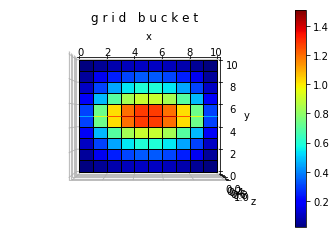

In [9]:
problem = DarcyMPFA(gb)
problem.solve()
problem.split('pressure')
pp.plot_grid(gb, 'pressure')